In [15]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
from PIL import Image
import math
import time
from numba import jit,njit,prange
from mpl_toolkits.mplot3d import Axes3D


from matplotlib.colors import LinearSegmentedColormap
import functools
import itertools as IT
import scipy.ndimage as ndimage
import matplotlib.colors as mcolors
import matplotlib.cm as cm

import sklearn
import pandas
from skimage import measure

In [2]:
# Load libraries
from pandas import read_csv
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

In [16]:
# comoving but the strings stay put (ideal for radiation or matter)


@jit(nopython = True)

def Laplacian(A,deltax,deltat):


    h = len(A)

    #CFL condition delta x => sqrt(D) delta t, where D is the number of dimensions            

    P = np.zeros((h,h,h))

    result = np.zeros((h,h,h))

    for i in range(0, h):

        for j in range(0,h):

            for k in range(0,h):

                P[i,j,k] = (A[(i-1)%h,(j-1)%h,(k-1)%h] + 3*A[(i-1)%h,j,(k-1)%h] + A[(i-1)%h,(j+1)%h,(k-1)%h] \

                + 3*A[(i-1)%h,(j-1)%h,k] + 14*A[(i-1)%h,j,k] + 3*A[(i-1)%h,(j+1)%h,k] \

                + A[(i-1)%h,(j-1)%h,(k+1)%h] + 3*A[(i-1)%h,j,(k+1)%h] + A[(i-1)%h,(j+1)%h,(k+1)%h] \

                + 3*A[i,(j-1)%h,(k-1)%h] + 14*A[i,j,(k-1)%h] + 3*A[i,(j+1)%h,(k-1)%h] \

                + 14*A[i,(j-1)%h,k] - 128*A[i,j,k] + 14*A[i,(j+1)%h,k] \

                + 3*A[i,(j-1)%h,(k+1)%h] + 14*A[i,j,(k+1)%h] + 3*A[i,(j+1)%h,(k+1)%h] \

                + A[(i+1)%h,(j-1)%h,(k-1)%h] + 3*A[(i+1)%h,j,(k-1)%h] + A[(i+1)%h,(j+1)%h,(k-1)%h] \

                + 3*A[(i+1)%h,(j-1)%h,k] + 14*A[(i+1)%h,j,k] + 3*A[(i+1)%h,(j+1)%h,k] \

                + A[(i+1)%h,(j-1)%h,(k+1)%h] + 3*A[(i+1)%h,j,(k+1)%h] + A[(i+1)%h,(j+1)%h,(k+1)%h])/(30*pow(deltax,2))

    return P 

def update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time):

    H_0 = 2.18e-18

    #a = np.sqrt(2*H_0)*np.sqrt(time)

    a = 4.75240000000367e-36 * time**2

    beta = 0

    alpha = 3

    #era = 1 #radiation

    era = 2 #matter


    lam = 2*pow(math.pi,2)/pow(omega,2)

  

    F1 = Laplacian(A1,deltax,deltat) - a**beta * lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*era*vel1*1/time

    F2 = Laplacian(A2,deltax,deltat) - a**beta * lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2))-alpha*era*vel2*1/time

    

    time = time + deltat

    

    a1 = 4.75240000000367e-36 * time**2

    

    A1 = A1 + deltat*(vel1 + 0.5*deltat*F1) 

    A2 = A2 + deltat*(vel2 + 0.5*deltat*F2) 



    vel1 = vel1 + deltat/2*(F1 + Laplacian(A1,deltax,deltat) - a1**beta *lam*A1*(pow(A1,2)+pow(A2,2)-pow(eta,2)) -alpha*era*vel1*1/time) 

    vel2 = vel2 + deltat/2*(F2 + Laplacian(A2,deltax,deltat) - a1**beta *lam*A2*(pow(A1,2)+pow(A2,2)-pow(eta,2)) -alpha*era*vel2*1/time)

    

    

    return A1,A2,vel1,vel2,a,time

    


def run(N,t0,t,A1,A2,vel,omega,eta,deltax,deltat):


    time = t0

    a = 0

    t0 = round(t0)


    vel1 = vel

    vel2 = vel



    for i in np.arange(int(t/deltat)):
            

        A1,A2,vel1,vel2,a,time = update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time)


    return A1,A2,vel1,vel2,time






In [18]:
import time

start = time.time()


n = 8
deltax = 1
deltat = 0.1
eta = 1
N = pow(2,n)
t = 0.5*N*deltax/deltat # light crossing time
t0 = 0.1
t2 = t/2 # half time
t5 = t/5
t10 = t/10 # 1/10 of the ligth crossing time
t20 = t/20

vel = np.zeros((N,N,N))
mu, sigma = 0, 0.1 # mean and standard deviation
omega = 5

print(t)



A1 = np.random.normal(mu, sigma, size=(N,N,N))
A2 = np.random.normal(mu,sigma,size=(N,N,N))




C1,C2,el1,el2,tim = run(N,t0,t20,A1,A2,vel,omega,eta,deltax,deltat)


end = time.time()
print(end - start)




1280.0
2230.9353108406067


In [23]:
def impose_periodic(check):
    for x in range(check.shape[0]):
        for y in range(check.shape[1]):
            for z in range(check.shape[2]):
                if check[0,y,z] > 0 and check[-1,y,z] > 0:
                    check[check == check[-1,y,z]] = check[0,y,z]
                if check[x,0,z] > 0 and check[x,-1,z] > 0:
                    check[check == check[x,-1,z]] = check[x,0,z]
                if check[x,y,0] > 0 and check[x,y,-1] > 0:
                    check[check == check[x,y,-1]] = check[x,y,0]
    return check


def wolff(N,t0,t,A1,A2,vel1,vel2,omega,eta,deltax,deltat):

    time = t0
    a = 0

    

    fig = plt.figure(figsize=(8,8))
    fig.set_facecolor('white')
    ax = fig.add_subplot(1, 1, 1, projection='3d')
    ax.set_facecolor('springgreen')
    #ax.set_axis_off()

    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_zticks([])
    
    ax.set_xlim3d(0,N)
    ax.set_ylim3d(0,N)
    ax.set_zlim3d(0,N)

    


    for i in np.arange(int(t/deltat)):
        time = round(time,2)     
        
        if time % 1 == 0:

            mod = np.sqrt(pow(A1,2)+pow(A2,2))**1 
            
            
            
            check = (mod > 0.05) & (mod < 0.5)
            
            points = np.where(check)
            
            #check = impose_periodic(check)
            
            
            
            _,num = skimage.measure.label(check,background = 0,return_num = True,connectivity = 3)

            scat = ax.scatter(points[0],points[1],points[2],color= 'black')

            plt.title(num)

            plt.savefig('6/'+str(int(time-t0)).zfill(3)+'.png')

            scat.remove()
            
            if num == 0:
                break


            
        A1,A2,vel1,vel2,a,time = update(N,A1,A2,vel1,vel2,omega,eta,deltax,deltat,a,time)


    return A1,A2




10939.335004091263


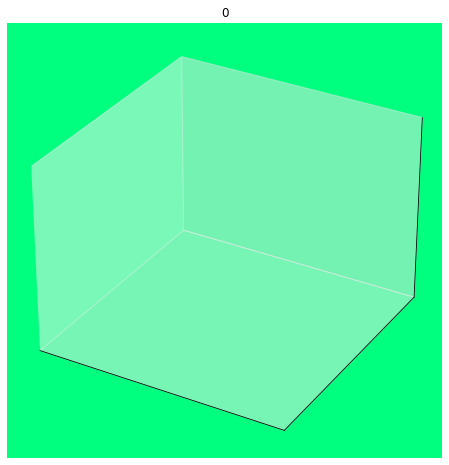

In [24]:
import time

start = time.time()


A1,A2 = wolff(N,tim,t2,C1,C2,el1,el2,omega,eta,deltax,deltat)




end = time.time()
print(end - start)

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [False False  True ...  True  True  True]]
27


<ipython-input-37-4a5fdb4eba83>:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1


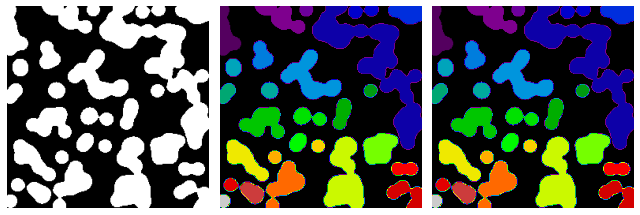

In [37]:
from skimage import measure
from skimage import filters
import matplotlib.pyplot as plt
import numpy as np

n = 12
l = 256
np.random.seed(1)
im = np.zeros((l, l))
points = l * np.random.random((2, n ** 2))
im[(points[0]).astype(np.int), (points[1]).astype(np.int)] = 1
im = filters.gaussian(im, sigma= l / (4. * n))
blobs = im > 0.7 * im.mean()

all_labels = measure.label(blobs)


print(blobs)
blobs_labels = measure.label(blobs, background=0,return_num = True)
print(blobs_labels[1])

plt.figure(figsize=(9, 3.5))
plt.subplot(131)
plt.imshow(blobs, cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(all_labels, cmap='nipy_spectral')
plt.axis('off')
plt.subplot(133)
plt.imshow(blobs_labels[0], cmap='nipy_spectral')
plt.axis('off')

plt.tight_layout()
plt.show()



In [5]:
# Load dataset
url = "https://raw.githubusercontent.com/jbrownlee/Datasets/master/iris.csv"
names = ['sepal-length', 'sepal-width', 'petal-length', 'petal-width', 'class']
dataset = read_csv(url, names=names)

In [6]:
# shape
print(dataset.shape)

(150, 5)


In [7]:
# head
print(dataset.head(20))

    sepal-length  sepal-width  petal-length  petal-width        class
0            5.1          3.5           1.4          0.2  Iris-setosa
1            4.9          3.0           1.4          0.2  Iris-setosa
2            4.7          3.2           1.3          0.2  Iris-setosa
3            4.6          3.1           1.5          0.2  Iris-setosa
4            5.0          3.6           1.4          0.2  Iris-setosa
5            5.4          3.9           1.7          0.4  Iris-setosa
6            4.6          3.4           1.4          0.3  Iris-setosa
7            5.0          3.4           1.5          0.2  Iris-setosa
8            4.4          2.9           1.4          0.2  Iris-setosa
9            4.9          3.1           1.5          0.1  Iris-setosa
10           5.4          3.7           1.5          0.2  Iris-setosa
11           4.8          3.4           1.6          0.2  Iris-setosa
12           4.8          3.0           1.4          0.1  Iris-setosa
13           4.3    

In [8]:
# descriptions
print(dataset.describe())

       sepal-length  sepal-width  petal-length  petal-width
count    150.000000   150.000000    150.000000   150.000000
mean       5.843333     3.054000      3.758667     1.198667
std        0.828066     0.433594      1.764420     0.763161
min        4.300000     2.000000      1.000000     0.100000
25%        5.100000     2.800000      1.600000     0.300000
50%        5.800000     3.000000      4.350000     1.300000
75%        6.400000     3.300000      5.100000     1.800000
max        7.900000     4.400000      6.900000     2.500000


In [9]:
# class distribution
print(dataset.groupby('class').size())

class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64


In [ ]:
# box and whisker plots
dataset.plot(kind='box', subplots=True, layout=(2,2), sharex=False, sharey=False)
pyplot.show()

In [ ]:
# histograms
dataset.hist()
pyplot.show()

In [ ]:
# scatter plot matrix
scatter_matrix(dataset)
pyplot.show()

In [ ]:
# Split-out validation dataset
array = dataset.values
X = array[:,0:4]
y = array[:,4]
X_train, X_validation, Y_train, Y_validation = train_test_split(X, y, test_size=0.20, random_state=1)

In [ ]:
# Spot Check Algorithms
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC(gamma='auto')))
# evaluate each model in turn
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

In [ ]:
# Compare Algorithms
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

In [ ]:
# Make predictions on validation dataset
model = SVC(gamma='auto')
model.fit(X_train, Y_train)
predictions = model.predict(X_validation)

In [ ]:
# Evaluate predictions
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))